In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset,random_split
import torch.nn.functional as F
import time
import os
import re
from itertools import chain
from transformers import BertTokenizer, BertForMaskedLM
from IPython.display import clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

PRETRAINED_MODEL_NAME = "bert-base-chinese" #英文pretrain(不區分大小寫)
print(torch.__version__)

1.7.0


In [3]:
# get pre-train tokenizer
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
vocab = tokenizer.vocab
print("dict size", len(vocab))

# see some token and index mapping
import random
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids): #隨便看幾個字
    print("{0:15}{1:10}".format(t, id))


dict size 21128
token               index          
-------------------------
104                  8503
winrar               9476
sql                  9078
yumi                11697
teddy               12764
##殲                 16722
##∣                 13536
##尔                 15266
蛭                    6036
nexus               10390


In [4]:
train = pd.read_csv('train.csv')
val = pd.read_csv('validation.csv')
total = pd.concat([train, val])
total = total.reset_index(drop=True)
total_0 = total[total["Label"] == 0]
total_1 = total[total["Label"] == 1]

In [5]:
# Label_1
num_1 = total_1.shape[0]
random_1 = random.sample(range(num_1), num_1)
train_1 = total_1.iloc[random_1[:108]]
test_1 = total_1.iloc[random_1[108:135]]
# Label_0
num_0 = total_0.shape[0]
random_0 = random.sample(range(num_0), num_0)
train_0 = total_0.iloc[random_0[:400]]
test_0 = total_0.iloc[random_0[400:500]]
# train_val_1
train_val_1 = train_1.shape[0]
random_train_val = random.sample(range(train_val_1), train_val_1)
train__1 = train_1.iloc[random_train_val[:97]]
val_1 = train_1.iloc[random_train_val[97:108]]
# train_val_0
train_val_0 = train_0.shape[0]
random_train_val = random.sample(range(train_val_0), train_val_0)
train__0 = train_0.iloc[random_train_val[:360]]
val_0 = train_0.iloc[random_train_val[360:400]]
# train_val
train = pd.concat([train__1, train__0])
train = train.reset_index(drop=True)
val = pd.concat([val_1, val_0])
val = val.reset_index(drop=True)
# test
test = pd.concat([test_1, test_0])
test = test.reset_index(drop=True)

In [6]:
def toList(data):
    df = []
    for j in range(len(data)):
        index = []
        index.append(data.iloc[j]['Content'])
        index.append(data.iloc[j]['Label'])
        df.append(index)
    return df

In [7]:
train = toList(train)
val = toList(val)
test = toList(test)
test

[['頭好痛怕失眠而造成失眠的焦慮感提早吃藥期望解決10點鬧鐘 盼望12點有睡意拒絕還是很難月初跟刺青師說 我要學會拒絕！但還是進步緩慢（至少我沒有以偏概全低落地說：我都做不到我很沒用）進步緩慢但還是有進步自從上個月自殺的舉動後正式進入輕躁期不過差不多要掉下來了 我感覺得到又要開始力不從心了...失去自控力好痛苦注意力不集中 不自信 與哭泣想要死亡的念頭又出現了我的創作力又差不多消失了該把?憂鬱這本書看完但是一直沒辦法好好閱讀完應該要趕快學些好辦法怎麼辦 好想在那天成功死掉現在我有恐懼感和各種低落情緒反而沒辦法走得快樂--',
  1],
 ['文長。睡前被悠樂丁強制關機好像沒存到檔只好重打....../因為童年陰影導致我非常害怕人在車上吵架，就算只是大小聲也都會讓我焦慮，偏偏昨天晚上我的爸媽直接在我面前重現我的夢魘：）最近畢業搬回家住，每個禮拜六就是全家（我弟偶爾回來）一起吃晚餐的日子，昨天因為媽媽在晚餐時間晚到家、以致我們要出門覓食的時候已經七點二十左右了，爸爸那時表示說要吃某間之前在路邊看到(?)的居酒屋，但因為沒人知道確切位置也不知道店名，我媽想說找到那間店不知道也什麼時候了就說：「但是現在很晚了。」就在我打算拿手機出來估狗居酒屋的時候，我爸直接爆炸怪我們拖太晚（但我其實也跟我爸一樣在家裡等我媽回來去吃飯），這時候我媽就不講話了、我在後座也看不到她的表情，下一秒我爸就突然發脾氣說：「阿不然要吃哪裡啦！」（他當下那個語氣就是如果前面有桌子他就會拍桌子的那種）然後接著又說我媽就是一臉不高興blahblahblah...整個車子裡的氣氛瞬間凍結，我也開始呼吸變得很淺、覺得好可怕好想下車你們為什麼要在車子裡吵架...後來我爸又說：「我不吃了。妳們看妳們要吃什麼我載妳們去。」媽媽就說：「你不要這樣子嘛...」在這期間我在後座什麼話也沒說，只默默地拿出鎮定劑吃、試著抑制我想隨時開車門逃走的衝動。因為我知道我這時候開車門走人只會讓情況更糟。最後還是有去吃飯。但整個吃飯的過程就是很尷尬。尷尬到隔壁桌或是店員可能都會覺得我們三個不認識一樣。回到家以後我躺在房間的地板上，想把自己殺掉的念頭越來越強烈，我馬上又吃了一顆鎮定劑、也打給男友，但那個念頭就是止不住。好想割手。我覺得好窒息。好想搬出去。為什麼他們自私地把我生下來、卻要把我夾在他們之間左右為難？我媽沒勇氣跟我爸離婚；我爸則

In [8]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df #its list [['text1',label],['text2',label],...]
        self.len = len(self.df)
        self.maxlen = 250 #限制文章長度(若你記憶體夠多也可以不限)
        self.tokenizer = tokenizer  # we will use BERT tokenizer
        
    def __getitem__(self, idx):
        origin_text = self.df[idx][0]
        text_a = self.df[idx][0]
        text_b = None  #for natural language inference
        #label_tensor = None #in our case, we have label
        label_id = self.df[idx][1]
        label_tensor = torch.tensor(label_id)
        
        # 建立第一個句子的 BERT tokens
        word_pieces = ["[CLS]"]
        tokens_a = self.tokenizer.tokenize(text_a)
        word_pieces += tokens_a[:self.maxlen] + ["[SEP]"]
        len_a = len(word_pieces)
        
        if text_b is not None:
            tokens_b = self.tokenizer.tokenize(text_b)
            word_pieces += tokens_b + ["[SEP]"]
            len_b = len(word_pieces) - len_a
            
        # 將整個 token 序列轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
        if text_b is None:
            segments_tensor = torch.tensor([1] * len_a,dtype=torch.long)
        elif text_b is not None:
            segments_tensor = torch.tensor([0] * len_a + [1] * len_b,dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor, origin_text)
    
    def __len__(self):
        return self.len

In [9]:
trainset = MyDataset(train, tokenizer=tokenizer)
valset = MyDataset(val, tokenizer=tokenizer)
testset = MyDataset(test, tokenizer=tokenizer)

In [10]:
# def MyDataset(Dataset):
#     data_len = len(Dataset)
#     maxlen = 250
#     text_a = Dataset['Content']
#     origin_text = Dataset['Content']
#     text_b = None  #for natural language inference
#     label_id = Dataset['Label']
#     label_tensor = torch.tensor(label_id)

#     # 建立第一個句子的 BERT tokens
#     word_pieces = []
#     for i in range(len(text_a)):
#         word_pieces += ["[CLS]"]
#         tokens_a = tokenizer.tokenize(text_a[i])
#         word_pieces += tokens_a[:maxlen] + ["[SEP]"]
#         len_a = len(word_pieces)
#         if text_b is not None:
#             tokens_b = self.tokenizer.tokenize(text_b)
#             word_pieces += tokens_b + ["[SEP]"]
#             len_b = len(word_pieces) - len_a
            
#     # 將整個 token 序列轉換成索引序列
#     ids = tokenizer.convert_tokens_to_ids(word_pieces)
#     tokens_tensor = torch.tensor(ids)
    
#     # 將第一句包含 [SEP] 的 token 位置設為 0，其他為 1 表示第二句
#     if text_b is None:
#         segments_tensor = torch.tensor([1] * len_a,dtype=torch.long)
#     elif text_b is not None:
#         segments_tensor = torch.tensor([0] * len_a + [1] * len_b,dtype=torch.long)

#     # 將 tokens_tensor 還原成文本
#     tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
    
#     print('token:\n',tokens,'\n')
#     print('origin_text:\n',origin_text,'\n')
#     print('tokens_tensor:\n',tokens_tensor,'\n')
#     print('segment tensor:\n',segments_tensor)
#     return (tokens_tensor, segments_tensor, label_tensor, origin_text, tokens)

In [11]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
""""
create_mini_batch(samples)吃上面定義的mydataset
回傳訓練 BERT 時會需要的 4 個 tensors：
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- segments_tensors: (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""
#collate_fn: 如何將多個樣本的資料連成一個batch丟進 model
#截長補短後要限制attention只注意非pad 的部分
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    # 訓練集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
        
    # zero pad到該batch下最長的長度
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors,batch_first=True)
    
    # attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1 讓 BERT 只關注這些位置的 tokens
    masks_tensors = torch.zeros(tokens_tensors.shape,dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

# 初始化一個每次回傳 batch size 個訓練樣本的 DataLoader
# 利用 'collate_fn' 將 list of samples 合併成一個 mini-batch
BATCH_SIZE = 91
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=False)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,collate_fn=create_mini_batch,shuffle=False)

data = next(iter(trainloader))
tokens_tensors, segments_tensors, masks_tensors, label_ids = data
print(tokens_tensors)
print(segments_tensors)
print(masks_tensors)
print(label_ids)

tensor([[ 101, 2769, 3221,  ...,    0,    0,    0],
        [ 101, 2828, 5632,  ...,    0,    0,    0],
        [ 101, 1920, 2157,  ...,    0,    0,    0],
        ...,
        [ 101,  791, 1921,  ...,    0,    0,    0],
        [ 101,  113, 7269,  ..., 7481, 2523,  102],
        [ 101, 5632, 3669,  ...,    0,    0,    0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

In [14]:
from transformers import BertForSequenceClassification

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME, num_labels=NUM_LABELS)


print("""
name      module
--------------------""")

for name, module in model.named_children():
    if name == "bert":
        for n, _ in module.named_children():
            print("{:10}{}".format(name,n) )
    else:
        print("{:10} {}".format(name, module))

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


name      module
--------------------
bert      embeddings
bert      encoder
bert      pooler
dropout    Dropout(p=0.1, inplace=False)
classifier Linear(in_features=768, out_features=2, bias=True)


In [15]:
%%time
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
EPOCHS = 10

for epoch in range(EPOCHS):
    correct = 0
    #total = 0
    train_loss , val_loss = 0.0 , 0.0
    train_acc, val_acc = 0, 0
    n, m = 0, 0
    model.train()
    for data in trainloader:
        n += 1
        tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]

        # 將參數梯度歸零
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
        # outputs 的順序是 "(loss), logits, (hidden_states), (attentions)"
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        #get prediction and calulate acc
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc += accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())

        # 紀錄當前 batch loss
        train_loss += loss.item()
    
    #validation
    with torch.no_grad():
        model.eval()
        for data in valloader:
            m += 1
            tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]
            val_outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)
            
            logits = val_outputs[1]
            _, pred = torch.max(logits.data, 1)
            val_acc += accuracy_score(pred.cpu().tolist() , labels.cpu().tolist())
            val_loss += val_outputs[0].item()

    print('[epoch %d] loss: %.4f, acc: %.4f, val loss: %4f, val acc: %4f' %
          (epoch+1, train_loss/n, train_acc/n, val_loss/m,  val_acc/m  ))

print('Done')

device: cpu
[epoch 1] loss: 0.5820, acc: 0.7033, val loss: 0.533880, val acc: 0.784314
[epoch 2] loss: 0.5889, acc: 0.7408, val loss: 0.518046, val acc: 0.784314
[epoch 3] loss: 0.4476, acc: 0.8205, val loss: 0.507522, val acc: 0.784314
[epoch 4] loss: 0.4767, acc: 0.8223, val loss: 0.487925, val acc: 0.784314
[epoch 5] loss: 0.5597, acc: 0.7408, val loss: 0.491307, val acc: 0.784314
[epoch 6] loss: 0.4279, acc: 0.8223, val loss: 0.477302, val acc: 0.784314
[epoch 7] loss: 0.4122, acc: 0.8242, val loss: 0.490291, val acc: 0.784314
[epoch 8] loss: 0.3912, acc: 0.8242, val loss: 0.480937, val acc: 0.784314
[epoch 9] loss: 0.3768, acc: 0.8370, val loss: 0.456119, val acc: 0.823529
[epoch 10] loss: 0.4106, acc: 0.7683, val loss: 0.443544, val acc: 0.803922
Done
CPU times: user 5h 33min 49s, sys: 3h 1min 11s, total: 8h 35min 1s
Wall time: 28min 26s


In [18]:
torch.save(model, 'bert_635.h5')

In [ ]:
# model = torch.load('bert_635.h5')

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

true=[]
predictions=[]
with torch.no_grad():
    model.eval()
    for data in testloader:
        tokens_tensors, segments_tensors,masks_tensors, labels = [t.to(device) for t in data]
        val_outputs = model(input_ids=tokens_tensors, 
                    token_type_ids=segments_tensors, 
                    attention_mask=masks_tensors, 
                    labels=labels)

        logits = val_outputs[1]
        _, pred = torch.max(logits.data, 1)
        true.extend(labels.cpu().tolist())
        predictions.extend(pred.cpu().tolist())


c = confusion_matrix(true, predictions)
print(c)
print('Accuracy Score: ', accuracy_score(true, predictions), '\n')

matrix = classification_report(true, predictions,labels=[1,0])
print('Classification report : \n', matrix)

[[100   0]
 [ 22   5]]
Accuracy Score:  0.8267716535433071 

Classification report : 
               precision    recall  f1-score   support

           1       1.00      0.19      0.31        27
           0       0.82      1.00      0.90       100

    accuracy                           0.83       127
   macro avg       0.91      0.59      0.61       127
weighted avg       0.86      0.83      0.78       127



In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.         0.        ]
 [0.81481481 0.18518519]]


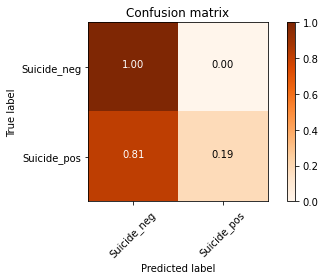

In [41]:
target_names = [ 'Suicide_neg','Suicide_pos']

plt.figure()
cnf_matrix = confusion_matrix(true, predictions)
plot_confusion_matrix(cnf_matrix, classes=target_names,normalize=True)

plt.show()

In [16]:
# torch.cuda.get_device_name(0)